# Traffic Signs Classifier Project 
Project by: Lucas Hagel

## Load Data

In [1]:
import pickle
import time
import pandas as pd
import importlib

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
  
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

labels_file = "signnames.csv"

with open(labels_file, mode = 'r') as ofo:
    classes = pd.read_csv(ofo)
num_classes = classes.shape[0]

print("Number of classes: {}".format(num_classes))
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))

def bing():
    '''
    Function makes a sound - to be used when model training/testing is complete
    '''
    pygame_spec = importlib.util.find_spec('pygame')
    if pygame_spec is not None:
        import pygame
        pygame.mixer.init()
        soundObj = pygame.mixer.Sound('beep1.ogg')
        soundObj.play()
        time.sleep(2)
        soundObj.stop()

Number of classes: 43
Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


## Visualize Data

We plot the number of each class label in the training set to see the distribution
(notice almost half of the classifications have under 500 training images)

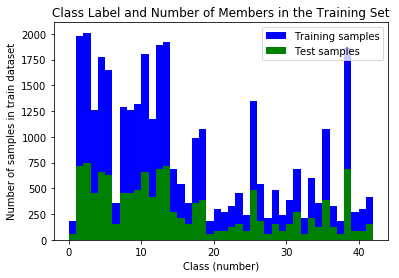

In [2]:
import numpy as np

from matplotlib import pyplot
import pandas as pd

%matplotlib inline

#class labels in a numpy array
signs_np_array = classes.as_matrix()

x = [i for i in range(num_classes)]

pyplot.hist(y_train, x,label='Training samples',color='blue')
pyplot.hist(y_test, x, label='Test samples', color='green')

pyplot.xlabel("Class (number)")
pyplot.ylabel("Number of samples in train dataset")
pyplot.title("Class Label and Number of Members in the Training Set")
pyplot.legend(loc='upper right')

pyplot.savefig("./visualization.jpg")

### A few images from the dataset.

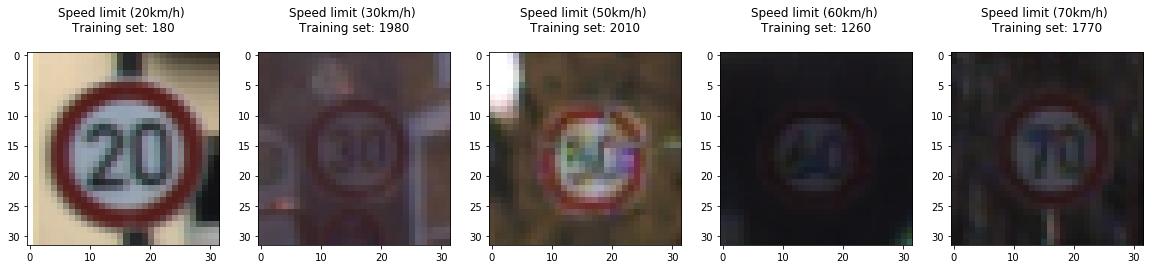

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

plt.figure(figsize=(20, 25))

count = Counter(y_train)
num_classes = 43
x = [i for i in range(num_classes)]
x_arr = [count[i] for i in range(num_classes)]

# gets the actual name of the image in question
def get_sign_label(index):
    for sign in signs_np_array:
        if sign[0] == index:
            return sign_class[1]
    return('Index not found')

for class_label in range(5):
    sign_class_id = signs_np_array[class_label, 0]     
    
    pic_id = None
    for i in range(len(y_train)):
        if y_train[i] == class_label:
            pic_id = i
            break
    
    label_actual_title = None
    for sign in signs_np_array:
        if sign[0] == class_label:
            label_actual_title = sign[1]    
   
    # + 1 is because it's a column number not zero indexed 
    plt.subplot(1, 5, class_label + 1)    
    title = "{0} \nTraining set: {1}\n".format(
        label_actual_title,        
        count[ class_label ])
    plt.title(title, wrap=True)
    plt.imshow(X_train[pic_id])


## Preprocess Data

#### Shuffle the training data.

In [4]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

#### Grayscale

In [5]:
import cv2
# Convert RGB to Grayscale:
def convert_RGB_to_grayscale(data):
    gray_img = []
    for i in range(0, len(data)):
        image = cv2.cvtColor(data[i], cv2.COLOR_RGB2GRAY)
        gray_img.append(image)
    data = np.reshape(gray_img, (-1, 32, 32, 1))
    return data

X_train = convert_RGB_to_grayscale(X_train)
X_valid = convert_RGB_to_grayscale(X_valid)
X_test = convert_RGB_to_grayscale(X_test)


#### Normalize the dataset: 

In [6]:
def vecI(vec):
    return (vec-128.)/128

X_train = [vecI(i) for i in X_train ]
X_valid = [vecI(i) for i in X_valid ]
X_test = [vecI(i) for i in X_test ]

## Model Architecture
This architecture is based on the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.


#### Input
This architecture accepts 32x32x1 (grayscaled) images as input.

#### Architecture

| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x1 Grayscale image						| 
| Convolution 5x5     	| 1x1 stride, Valid Padding, outputs 28x28x64 	|
| Max pooling			| 2x2 stride, outputs 14x14x64					|
| ReLU  				| 												|
| Convolution 5x5     	| 1x1 stride, Valid padding, outputs 10x10x128	|
| Max pooling			| 2x2 stride,  outputs 5x5x128					|
| ReLU	      			| 												|
| Flatten				| flatten to a 1D vector 3200 outputs			|
| Fully connected		| 400 outputs 									|
| Dropout      			| keep probability = .5							|
| ReLU	      			| 												|
| Fully connected		| 84 outputs 									|
| Dropout      			| keep probability = .5							|
| ReLU	      			| 												|
| Fully connected		| 43 outputs 									|


In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x,keep_prob):    
    mu = 0
    sigma = 0.1    
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x64.
    weight_layer_1 = tf.Variable(tf.truncated_normal((5,5, 1, 64),mu,sigma))
    bias_1 = tf.Variable(tf.zeros(64))
    #Activation.
    layer_1 = tf.nn.conv2d(x, weight_layer_1, [1,1,1,1], padding='VALID') + bias_1
    layer_1 = tf.nn.relu(layer_1)
    
    #Pooling. Input = 28x28x16. Output = 14x14x16.   
    layer_1 = tf.nn.max_pool(layer_1,
                             ksize=[1, 2,2, 1],
                             strides=[1, 2,2, 1],
                           padding='VALID')
    
    #Layer 2: Convolutional. Output = 10x10x32.    
    weight_layer_2 = tf.Variable(tf.truncated_normal((5,5, 64, 128),mu,sigma))
    bias_2 = tf.Variable(tf.zeros(128))
    layer_2 = tf.nn.conv2d(layer_1, weight_layer_2, 
                           strides=[1, 1, 1, 1], padding='VALID') + bias_2
    layer_2 = tf.nn.relu(layer_2)
    
    #Pooling. Input = 10x10x32. Output = 5x5x32.
    layer_2 = tf.nn.max_pool(layer_2,
                             ksize=[1, 2,2, 1],
                             strides=[1,2,2, 1],
                            padding='VALID')    
    
    #Flatten. Input = 5x5x32. Output = 3200.  
    layer_2 = flatten(layer_2)      
          
    #Layer 3: Fully Connected. Input = 3200. Output = 400.    
    weight_layer_3 = tf.Variable(tf.truncated_normal((3200,400),mu,sigma))
    bias_3 = tf.Variable( tf.zeros(400) )
    l3_fc1 = tf.matmul(layer_2, weight_layer_3) + bias_3
    
    #Dropout and Activation.
    l3_fc1 = tf.nn.dropout(l3_fc1,keep_prob) 
    l3_fc1 = tf.nn.relu(l3_fc1)
    
    #Layer 4: Fully Connected. Input = 400. Output = 84.
    weight_layer_4 = tf.Variable(tf.truncated_normal((400,84),mu,sigma))
    bias_4 = tf.Variable(tf.zeros(84))
    l4_fc2 = tf.matmul(l3_fc1, weight_layer_4) + bias_4
    
    #Dropout and Activation.
    l4_fc2 = tf.nn.dropout(l4_fc2,keep_prob)
    l4_fc2 = tf.nn.relu(l4_fc2)   
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    weight_layer_5 = tf.Variable(tf.truncated_normal((84,43),mu,sigma))
    bias_5 = tf.Variable(tf.zeros(43))    
    logits = tf.matmul(l4_fc2, weight_layer_5) +  bias_5
    
    return logits

## Training Pipeline


### Training Pipeline

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

In [ ]:
EPOCHS = 18
BATCH_SIZE = 256

#tensor to store the keep probability for dropout
keep_prob = tf.placeholder(tf.float32, (None))
one_hot_y = tf.one_hot(y, 43)

#learning rate
rate = 0.0005

logits = LeNet(x,keep_prob)

#cross_entropy is the difference between the model classification set and the set 
# against which it is being compared. 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

# Adam optimizer, an alternative to stochastic gradient descent
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# checks if each model output matches that of y-value from the input 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def evaluate(X_data, y_data, keep_proba):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob : keep_proba})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy / num_examples, total_loss / num_examples)

## Train the Model
1. Run the training data through the training pipeline to train the model.
2. Before each epoch, shuffle the training set.
3. After each epoch, measure the loss and accuracy of the validation set.
4. Save the model after training.

In [ ]:
start = time.time()
valid_accuracy_arr = []
loss_arr = []

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # shuffle the data before each EPOCH to eliminate bias
        X_train, y_train = shuffle(X_train, y_train)
        
        #train 1 batch at a time
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : .5})
        
        #evaluate the validation accuracy and print it each epoch    
        validation_accuracy = evaluate(X_valid, y_valid,1)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}, loss = {:.3f}".format(validation_accuracy[0], validation_accuracy[1]))
        print()
        valid_accuracy_arr.append(validation_accuracy[0])
        loss_arr.append(validation_accuracy[1])
        
    saver.save(sess, './lenet')
    print("Model saved")
fina = time.time()
print("It took {:.3f} sec to train".format(fina-start))

Training...

EPOCH 1 ...
Validation Accuracy = 0.354, loss = 2.536



#### Plots of the accuracy and loss after each epoch for a visual of model training progress

In [ ]:
plt.figure(1)
plt.subplot(211)
plt.plot(valid_accuracy_arr)
plt.ylabel('Accuracy')
plt.show()

plt.figure(1)
plt.subplot(212)
plt.plot(loss_arr)
plt.ylabel('Loss')
plt.show()

## Model Evaluation


In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test,1)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]))

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    train_accuracy = evaluate(X_train, y_train,1)
    print("Train Accuracy = {:.3f}".format(train_accuracy[0]))


Have the program make a sound when training is complete.

In [ ]:
bing()

In [ ]:
import matplotlib.image as mpimg
import os
import cv2
from copy import deepcopy
img_path = "GermanTrafficSigns/"
web_img_list = os.listdir(img_path)

german_signs = []
y_german_signs = []

for pic in web_img_list:
    img = cv2.imread(img_path + pic)    
    if img is not None:
        y_german_signs.append( int(pic[:2]) )
        img = cv2.resize(img, (32,32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        german_signs.append(img)
    
german_signs_orig = deepcopy(german_signs)
german_signs = convert_RGB_to_grayscale(german_signs)

german_signs = [vecI(i) for i in german_signs]
german_signs = np.array(german_signs)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logits_web = sess.run(logits, feed_dict={x: german_signs, y: y_german_signs, keep_prob:1})
    new_set_accuracy = evaluate(german_signs, y_german_signs,1)
    print("Test Accuracy = {:.3f}".format(new_set_accuracy[0]))

In [ ]:
plt.figure(figsize=(20, 25))
for i in range(len(y_german_signs)):
    title = signs_np_array[y_german_signs[i], 1]    
    plt.subplot(1, 5, i + 1)
    plt.title(title, wrap=True)
    plt.imshow(german_signs_orig[i])

In [ ]:
softmax = tf.nn.softmax(logits)
#top_k --> finds values and indices of the k largest entries for the last dimension
top_five = tf.nn.top_k(softmax, 5)

predictions = None
prediction_indices = None
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    result = sess.run(top_five, feed_dict={x: german_signs, keep_prob: 1})
    predictions  = result.values
    prediction_indices  = result.indices
    np.set_printoptions(precision=4)

labels = [[signs_np_array[i][1] for i in row] for row in prediction_indices]
print()
for i in range(len(predictions)):
    print("Picture {}".format(str(i+1)))
    for prob in range(len(predictions)):
        print( str(predictions[i][prob] ) + " --> " + labels[i][prob])
    print()